In [ ]:
#PLAICRAFT Data Analysis - following my proposal, doing a KNN regression using every trait in the players data to see if we can correctly classify gender

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<dbl>,<dbl>,<dbl>,<fct>,<dbl>
3,1,30.3,Male,9
4,1,3.8,Male,17
4,0,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
2,1,0.0,Female,17
4,0,0.3,Male,22
2,0,2.3,Male,17


Warning message:
“Removed 30 rows containing non-finite outside the scale range (`stat_count()`).”


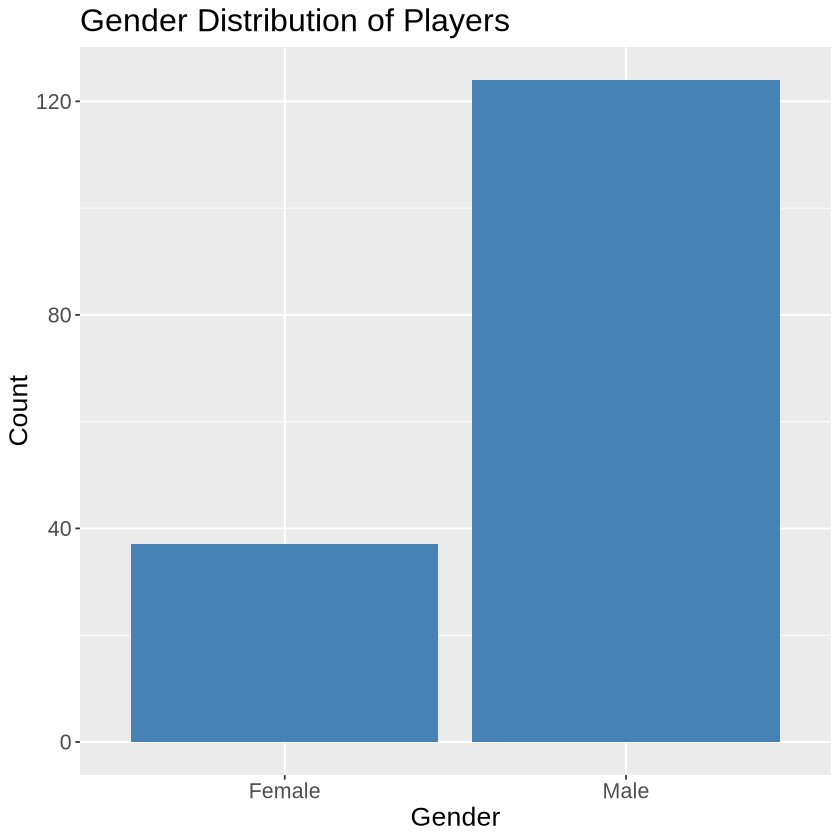

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 53 rows.
               ✖ Assigned data has 65 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 65 to size 53.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 49 rows.
               ✖ Assigned data has 63 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 63 to size 49.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1



Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in `estimate_tune_results()`:[22m
[33m![39m All models failed. Run `show_notes(.Last.tune.result)` for more information.


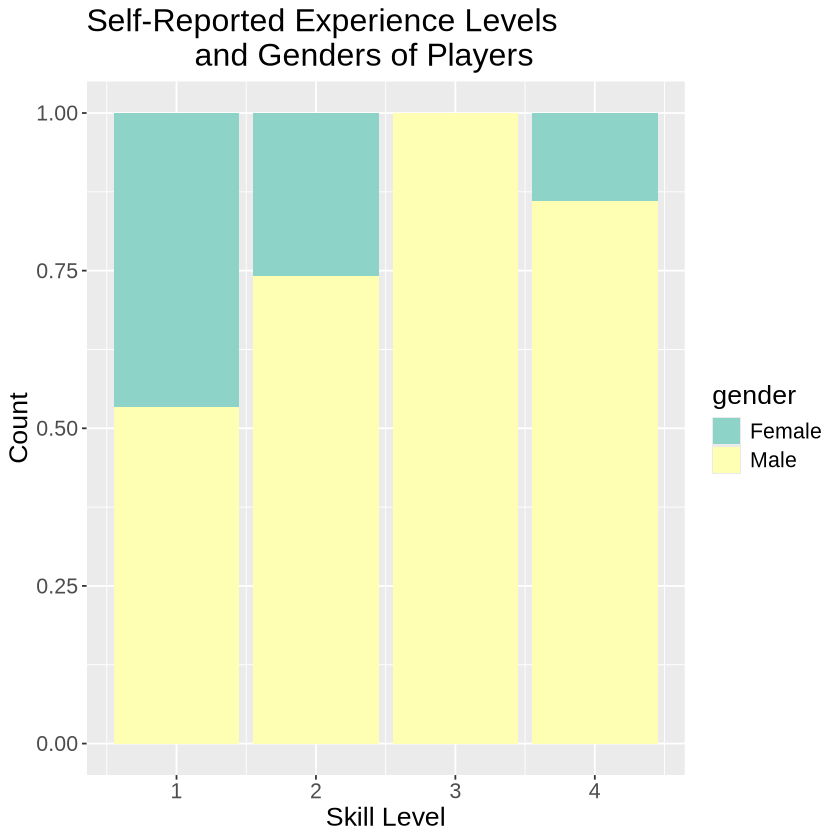

In [47]:
set.seed(8888) #don't remove pleaaaaseeee

#experience is now scored from 1 to 4, with 1 being the most beginner and 4 being the most advanced
#subscription is now scored from 0 to 1, where 0 is not subscribed and 1 is subscribed
players <- read_csv("https://raw.githubusercontent.com/ellailan/PLAICRAFT-Data-Analysis/refs/heads/main/players.csv") |>
            filter(gender == "Male" | gender == "Female") |>  #for the sake of simplicity.... but could be argued against? can be tinkered w/ later |>
            select(-hashedEmail, -name) |>
            mutate(gender = as.factor(gender)) |>
            mutate(experience = as.numeric(factor(experience, 
                                              levels = c("Beginner", "Amateur", "Pro", "Veteran")))) |>
            mutate(subscribe = as.numeric(subscribe))

players


#visualizing some things that we can see abt. gender makeup of surveyed participants
gender <- players |> ggplot(aes(x = gender)) +
  geom_bar(fill = "steelblue") +
  labs(title = "Gender Distribution of Players", x = "Gender", y = "Count") +
    theme(text = element_text(size = 16)) 


experience_gender <- players |> ggplot(aes(x = experience, fill = gender)) +
  geom_bar(position = "fill") +
  labs(color = "Gender", y = "Count", x = "Skill Level") + 
    ggtitle("Self-Reported Experience Levels
            and Genders of Players") +
    theme(text = element_text(size = 16)) +
    scale_fill_brewer(palette = 'Set3')

gender
experience_gender


#splitting data into testing and training, using the proportion reccomended by TA as feedback to proposal 
gender_split <- initial_split(players, prop = 0.80, strata = gender)
gender_train <- training(gender_split)   
gender_test <- testing(gender_split)


#KNN classification 

vfold <- vfold_cv(gender_train, v = 2, strata = gender)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")


#excluding playtime bc of outlying data, also debatable
knn_recipe <- recipe(gender ~ experience + subscribe + Age, data = gender_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())


knn_results <- workflow() |>
      add_recipe(knn_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = vfold, grid = k_vals) |>
      collect_metrics() 

